# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

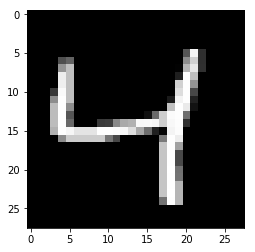

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [5]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 32 # feel free to change this value

image_size = mnist.train.images.shape[1]

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, image_size], name="inputs") #행의 수는 정해지지 않았고, 열의 수는 image_size
#몇 개의 이미지를 넣을지는 정해지지 않았지만, 한 이미지는 image_size만큼의 요소로 구성된다.
targets_ = tf.placeholder(tf.float32, [None, image_size], name="targets") #행의 수는 정해지지 않았고, 열의 수는 image_size
#몇 개의 정답 레이블을 넣을지는 정해지지 않았지만, 한 정답 레이블은 image_size만큼의 요소로 구성된다 (input과 같다).
#name을 쓰지 않을 경우, 저장된 가중치, 편향을 불러올 때 문제가 있을 수 있다.
#inputs_, targets_은 값이 변하지 않지만, 런타임시 값을 지정해 줘야 하므로 placeholder

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs_, encoding_dim, activation=tf.nn.relu)
#tf.layers.dense를 사용해 fully connected 신경망을 만들 수 있다. 파라미터는 (인풋, 출력 차원(아웃풋 사이즈)). 나머지는 모두 optional. 
#Relu를 활성화함수로. 따로 추가해 줘도 된다. 

# Output layer logits, fully connected layer with no activation
logits = tf.layers.dense(encoded, image_size, activation=None) #손실을 쉽게 구하기 위해 활성함수 시그모이드를 따로 추가해 준다.
#위의 그림과 같이 인코딩한 것을 디코딩하므로 인풋, 출력 차원(아웃풋 사이즈)를 맞춰줄 수 있다.

# Sigmoid output from logits
decoded = tf.nn.sigmoid(logits, name="output") #시그모이드 추가
#이미지가 위에서 0과 1사이에서 정규화되었기 때문에 시그모이드로 값을 출력해 이미지를 재구성할 수 있다.

# Sigmoid cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits) #손실 구하기
#sigmoid_cross_entropy_with_logits 이므로 정답레이블과 시그모이드 이전의 로짓을 넣어주면 된다.

# Mean of the loss
cost = tf.reduce_mean(loss) #텐서 차원에서의 요소 평균을 구한다. #reduce_sum도 있다.

# Adam optimizer
opt = tf.train.AdamOptimizer(0.001).minimize(cost) #학습률 0.001로 cost가 최소가 되도록 Adam 최적화

## Training

In [6]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [7]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer()) #Variable 초기화
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]} #인코딩 - 디코딩이므로, input과 target이 같다.
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed) 
        #최종 목적은 optimizer 따라서, sess.run()으로 실행한다. #cost는 학습이 잘 되고 있나 출력하기 위해.
        #feed_dict로 placeholder에 필요한 값들을 KVC로 넣어주면 된다. 

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6948
Epoch: 1/20... Training loss: 0.6922
Epoch: 1/20... Training loss: 0.6900
Epoch: 1/20... Training loss: 0.6878
Epoch: 1/20... Training loss: 0.6849
Epoch: 1/20... Training loss: 0.6818
Epoch: 1/20... Training loss: 0.6758
Epoch: 1/20... Training loss: 0.6720
Epoch: 1/20... Training loss: 0.6663
Epoch: 1/20... Training loss: 0.6578
Epoch: 1/20... Training loss: 0.6489
Epoch: 1/20... Training loss: 0.6395
Epoch: 1/20... Training loss: 0.6263
Epoch: 1/20... Training loss: 0.6161
Epoch: 1/20... Training loss: 0.6010
Epoch: 1/20... Training loss: 0.5884
Epoch: 1/20... Training loss: 0.5710
Epoch: 1/20... Training loss: 0.5571
Epoch: 1/20... Training loss: 0.5359
Epoch: 1/20... Training loss: 0.5161
Epoch: 1/20... Training loss: 0.4952
Epoch: 1/20... Training loss: 0.4782
Epoch: 1/20... Training loss: 0.4613
Epoch: 1/20... Training loss: 0.4500
Epoch: 1/20... Training loss: 0.4307
Epoch: 1/20... Training loss: 0.4115
Epoch: 1/20... Training loss: 0.3972
E

Epoch: 1/20... Training loss: 0.2078
Epoch: 1/20... Training loss: 0.2122
Epoch: 1/20... Training loss: 0.2070
Epoch: 1/20... Training loss: 0.2092
Epoch: 1/20... Training loss: 0.2089
Epoch: 1/20... Training loss: 0.2005
Epoch: 1/20... Training loss: 0.2031
Epoch: 1/20... Training loss: 0.2141
Epoch: 1/20... Training loss: 0.2251
Epoch: 1/20... Training loss: 0.2028
Epoch: 1/20... Training loss: 0.2112
Epoch: 1/20... Training loss: 0.2111
Epoch: 1/20... Training loss: 0.2138
Epoch: 1/20... Training loss: 0.2042
Epoch: 1/20... Training loss: 0.2003
Epoch: 1/20... Training loss: 0.2170
Epoch: 1/20... Training loss: 0.2074
Epoch: 1/20... Training loss: 0.2174
Epoch: 1/20... Training loss: 0.2068
Epoch: 1/20... Training loss: 0.2078
Epoch: 1/20... Training loss: 0.1941
Epoch: 1/20... Training loss: 0.2037
Epoch: 1/20... Training loss: 0.2055
Epoch: 1/20... Training loss: 0.2002
Epoch: 1/20... Training loss: 0.1916
Epoch: 1/20... Training loss: 0.1962
Epoch: 1/20... Training loss: 0.2041
E

Epoch: 2/20... Training loss: 0.1671
Epoch: 2/20... Training loss: 0.1677
Epoch: 2/20... Training loss: 0.1631
Epoch: 2/20... Training loss: 0.1686
Epoch: 2/20... Training loss: 0.1692
Epoch: 2/20... Training loss: 0.1651
Epoch: 2/20... Training loss: 0.1655
Epoch: 2/20... Training loss: 0.1712
Epoch: 2/20... Training loss: 0.1697
Epoch: 2/20... Training loss: 0.1681
Epoch: 2/20... Training loss: 0.1664
Epoch: 2/20... Training loss: 0.1633
Epoch: 2/20... Training loss: 0.1594
Epoch: 2/20... Training loss: 0.1625
Epoch: 2/20... Training loss: 0.1683
Epoch: 2/20... Training loss: 0.1672
Epoch: 2/20... Training loss: 0.1650
Epoch: 2/20... Training loss: 0.1661
Epoch: 2/20... Training loss: 0.1613
Epoch: 2/20... Training loss: 0.1679
Epoch: 2/20... Training loss: 0.1610
Epoch: 2/20... Training loss: 0.1656
Epoch: 2/20... Training loss: 0.1691
Epoch: 2/20... Training loss: 0.1692
Epoch: 2/20... Training loss: 0.1626
Epoch: 2/20... Training loss: 0.1666
Epoch: 2/20... Training loss: 0.1722
E

Epoch: 3/20... Training loss: 0.1402
Epoch: 3/20... Training loss: 0.1442
Epoch: 3/20... Training loss: 0.1486
Epoch: 3/20... Training loss: 0.1503
Epoch: 3/20... Training loss: 0.1495
Epoch: 3/20... Training loss: 0.1484
Epoch: 3/20... Training loss: 0.1457
Epoch: 3/20... Training loss: 0.1473
Epoch: 3/20... Training loss: 0.1472
Epoch: 3/20... Training loss: 0.1502
Epoch: 3/20... Training loss: 0.1435
Epoch: 3/20... Training loss: 0.1506
Epoch: 3/20... Training loss: 0.1472
Epoch: 3/20... Training loss: 0.1431
Epoch: 3/20... Training loss: 0.1492
Epoch: 3/20... Training loss: 0.1475
Epoch: 3/20... Training loss: 0.1439
Epoch: 3/20... Training loss: 0.1420
Epoch: 3/20... Training loss: 0.1431
Epoch: 3/20... Training loss: 0.1467
Epoch: 3/20... Training loss: 0.1452
Epoch: 3/20... Training loss: 0.1440
Epoch: 3/20... Training loss: 0.1486
Epoch: 3/20... Training loss: 0.1395
Epoch: 3/20... Training loss: 0.1419
Epoch: 3/20... Training loss: 0.1441
Epoch: 3/20... Training loss: 0.1472
E

Epoch: 4/20... Training loss: 0.1358
Epoch: 4/20... Training loss: 0.1311
Epoch: 4/20... Training loss: 0.1384
Epoch: 4/20... Training loss: 0.1272
Epoch: 4/20... Training loss: 0.1336
Epoch: 4/20... Training loss: 0.1359
Epoch: 4/20... Training loss: 0.1306
Epoch: 4/20... Training loss: 0.1355
Epoch: 4/20... Training loss: 0.1326
Epoch: 4/20... Training loss: 0.1342
Epoch: 4/20... Training loss: 0.1324
Epoch: 4/20... Training loss: 0.1406
Epoch: 4/20... Training loss: 0.1357
Epoch: 4/20... Training loss: 0.1310
Epoch: 4/20... Training loss: 0.1362
Epoch: 4/20... Training loss: 0.1256
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1291
Epoch: 4/20... Training loss: 0.1309
Epoch: 4/20... Training loss: 0.1375
Epoch: 4/20... Training loss: 0.1354
Epoch: 4/20... Training loss: 0.1295
Epoch: 4/20... Training loss: 0.1305
Epoch: 4/20... Training loss: 0.1343
Epoch: 4/20... Training loss: 0.1292
Epoch: 4/20... Training loss: 0.1281
Epoch: 4/20... Training loss: 0.1373
E

Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1240
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1226
Epoch: 4/20... Training loss: 0.1244
Epoch: 4/20... Training loss: 0.1241
Epoch: 4/20... Training loss: 0.1241
Epoch: 4/20... Training loss: 0.1261
Epoch: 4/20... Training loss: 0.1231
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1226
Epoch: 4/20... Training loss: 0.1234
Epoch: 4/20... Training loss: 0.1200
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1235
Epoch: 4/20... Training loss: 0.1156
Epoch: 4/20... Training loss: 0.1220
E

Epoch: 5/20... Training loss: 0.1219
Epoch: 5/20... Training loss: 0.1168
Epoch: 5/20... Training loss: 0.1126
Epoch: 5/20... Training loss: 0.1162
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1114
Epoch: 5/20... Training loss: 0.1156
Epoch: 5/20... Training loss: 0.1109
Epoch: 5/20... Training loss: 0.1177
Epoch: 5/20... Training loss: 0.1117
Epoch: 5/20... Training loss: 0.1143
Epoch: 5/20... Training loss: 0.1159
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1120
Epoch: 5/20... Training loss: 0.1145
Epoch: 5/20... Training loss: 0.1161
Epoch: 5/20... Training loss: 0.1155
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1143
Epoch: 5/20... Training loss: 0.1147
Epoch: 5/20... Training loss: 0.1087
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1130
Epoch: 5/20... Training loss: 0.1149
Epoch: 5/20... Training loss: 0.1150
E

Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1039
Epoch: 6/20... Training loss: 0.1099
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1126
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1106
Epoch: 6/20... Training loss: 0.1110
Epoch: 6/20... Training loss: 0.1038
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1047
Epoch: 6/20... Training loss: 0.1128
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1067
Epoch: 6/20... Training loss: 0.1085
Epoch: 6/20... Training loss: 0.1040
Epoch: 6/20... Training loss: 0.1067
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1116
Epoch: 6/20... Training loss: 0.1068
Epoch: 6/20... Training loss: 0.1093
Epoch: 6/20... Training loss: 0.1103
E

Epoch: 7/20... Training loss: 0.1035
Epoch: 7/20... Training loss: 0.1024
Epoch: 7/20... Training loss: 0.1048
Epoch: 7/20... Training loss: 0.1063
Epoch: 7/20... Training loss: 0.1099
Epoch: 7/20... Training loss: 0.1057
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1065
Epoch: 7/20... Training loss: 0.1048
Epoch: 7/20... Training loss: 0.1102
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1066
Epoch: 7/20... Training loss: 0.1019
Epoch: 7/20... Training loss: 0.1052
Epoch: 7/20... Training loss: 0.1084
Epoch: 7/20... Training loss: 0.1051
Epoch: 7/20... Training loss: 0.1017
Epoch: 7/20... Training loss: 0.1040
Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1048
Epoch: 7/20... Training loss: 0.1061
Epoch: 7/20... Training loss: 0.1042
Epoch: 7/20... Training loss: 0.1053
Epoch: 7/20... Training loss: 0.1039
E

Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.1009
Epoch: 7/20... Training loss: 0.1005
Epoch: 7/20... Training loss: 0.1034
Epoch: 7/20... Training loss: 0.0998
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.0983
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.1034
Epoch: 7/20... Training loss: 0.0990
Epoch: 7/20... Training loss: 0.1012
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.1008
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.0997
Epoch: 7/20... Training loss: 0.0996
Epoch: 7/20... Training loss: 0.1005
Epoch: 7/20... Training loss: 0.0997
Epoch: 7/20... Training loss: 0.0987
Epoch: 7/20... Training loss: 0.1041
Epoch: 7/20... Training loss: 0.0991
Epoch: 7/20... Training loss: 0.1022
Epoch: 7/20... Training loss: 0.1071
Epoch: 7/20... Training loss: 0.1012
Epoch: 7/20... Training loss: 0.1005
Epoch: 7/20... Training loss: 0.1027
E

Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.0976
Epoch: 8/20... Training loss: 0.1051
Epoch: 8/20... Training loss: 0.0972
Epoch: 8/20... Training loss: 0.1023
Epoch: 8/20... Training loss: 0.0956
Epoch: 8/20... Training loss: 0.0966
Epoch: 8/20... Training loss: 0.0988
Epoch: 8/20... Training loss: 0.0971
Epoch: 8/20... Training loss: 0.1011
Epoch: 8/20... Training loss: 0.0975
Epoch: 8/20... Training loss: 0.0988
Epoch: 8/20... Training loss: 0.0981
Epoch: 8/20... Training loss: 0.0994
Epoch: 8/20... Training loss: 0.1031
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.0955
Epoch: 8/20... Training loss: 0.0978
Epoch: 8/20... Training loss: 0.1012
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.1029
Epoch: 8/20... Training loss: 0.0964
Epoch: 8/20... Training loss: 0.0987
Epoch: 8/20... Training loss: 0.0959
Epoch: 8/20... Training loss: 0.0964
E

Epoch: 9/20... Training loss: 0.0992
Epoch: 9/20... Training loss: 0.0971
Epoch: 9/20... Training loss: 0.0962
Epoch: 9/20... Training loss: 0.0990
Epoch: 9/20... Training loss: 0.0976
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0965
Epoch: 9/20... Training loss: 0.0982
Epoch: 9/20... Training loss: 0.0954
Epoch: 9/20... Training loss: 0.0977
Epoch: 9/20... Training loss: 0.1010
Epoch: 9/20... Training loss: 0.0994
Epoch: 9/20... Training loss: 0.1016
Epoch: 9/20... Training loss: 0.0978
Epoch: 9/20... Training loss: 0.0990
Epoch: 9/20... Training loss: 0.0962
Epoch: 9/20... Training loss: 0.0974
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0990
Epoch: 9/20... Training loss: 0.0987
Epoch: 9/20... Training loss: 0.0945
Epoch: 9/20... Training loss: 0.0985
Epoch: 9/20... Training loss: 0.0970
Epoch: 9/20... Training loss: 0.0979
Epoch: 9/20... Training loss: 0.0947
Epoch: 9/20... Training loss: 0.0988
Epoch: 9/20... Training loss: 0.0950
E

Epoch: 10/20... Training loss: 0.0973
Epoch: 10/20... Training loss: 0.0943
Epoch: 10/20... Training loss: 0.1013
Epoch: 10/20... Training loss: 0.0963
Epoch: 10/20... Training loss: 0.0952
Epoch: 10/20... Training loss: 0.0993
Epoch: 10/20... Training loss: 0.0955
Epoch: 10/20... Training loss: 0.0935
Epoch: 10/20... Training loss: 0.0945
Epoch: 10/20... Training loss: 0.0954
Epoch: 10/20... Training loss: 0.0955
Epoch: 10/20... Training loss: 0.0976
Epoch: 10/20... Training loss: 0.0996
Epoch: 10/20... Training loss: 0.0947
Epoch: 10/20... Training loss: 0.0953
Epoch: 10/20... Training loss: 0.0993
Epoch: 10/20... Training loss: 0.0961
Epoch: 10/20... Training loss: 0.0969
Epoch: 10/20... Training loss: 0.0961
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0964
Epoch: 10/20... Training loss: 0.0952
Epoch: 10/20... Training loss: 0.0954
Epoch: 10/20... Training loss: 0.0959
Epoch: 10/20... Training loss: 0.0993
Epoch: 10/20... Training loss: 0.0945
Epoch: 10/20

Epoch: 10/20... Training loss: 0.0951
Epoch: 10/20... Training loss: 0.0988
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.1004
Epoch: 10/20... Training loss: 0.0940
Epoch: 10/20... Training loss: 0.0976
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.0957
Epoch: 10/20... Training loss: 0.0966
Epoch: 10/20... Training loss: 0.0963
Epoch: 10/20... Training loss: 0.0942
Epoch: 10/20... Training loss: 0.0913
Epoch: 10/20... Training loss: 0.0964
Epoch: 10/20... Training loss: 0.0956
Epoch: 10/20... Training loss: 0.0970
Epoch: 10/20... Training loss: 0.0928
Epoch: 10/20... Training loss: 0.0970
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0951
Epoch: 10/20... Training loss: 0.0983
Epoch: 10/20... Training loss: 0.0943
Epoch: 10/20... Training loss: 0.0945
Epoch: 10/20... Training loss: 0.0974
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0988
Epoch: 10/20... Training loss: 0.0937
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0952
Epoch: 11/20... Training loss: 0.0985
Epoch: 11/20... Training loss: 0.0937
Epoch: 11/20... Training loss: 0.0938
Epoch: 11/20... Training loss: 0.0953
Epoch: 11/20... Training loss: 0.0953
Epoch: 11/20... Training loss: 0.0974
Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0939
Epoch: 11/20... Training loss: 0.0954
Epoch: 11/20... Training loss: 0.0956
Epoch: 11/20... Training loss: 0.0936
Epoch: 11/20... Training loss: 0.0925
Epoch: 11/20... Training loss: 0.0924
Epoch: 11/20... Training loss: 0.0940
Epoch: 11/20... Training loss: 0.0978
Epoch: 11/20... Training loss: 0.0986
Epoch: 11/20... Training loss: 0.1011
Epoch: 11/20... Training loss: 0.0968
Epoch: 11/20... Training loss: 0.0941
Epoch: 11/20... Training loss: 0.0935
Epoch: 11/20... Training loss: 0.0932
Epoch: 11/20... Training loss: 0.0929
Epoch: 11/20... Training loss: 0.0932
Epoch: 11/20... Training loss: 0.0937
Epoch: 11/20... Training loss: 0.0967
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0925
Epoch: 12/20... Training loss: 0.0947
Epoch: 12/20... Training loss: 0.0961
Epoch: 12/20... Training loss: 0.0955
Epoch: 12/20... Training loss: 0.0949
Epoch: 12/20... Training loss: 0.0940
Epoch: 12/20... Training loss: 0.0981
Epoch: 12/20... Training loss: 0.0967
Epoch: 12/20... Training loss: 0.0980
Epoch: 12/20... Training loss: 0.0946
Epoch: 12/20... Training loss: 0.0905
Epoch: 12/20... Training loss: 0.0951
Epoch: 12/20... Training loss: 0.0938
Epoch: 12/20... Training loss: 0.0972
Epoch: 12/20... Training loss: 0.0981
Epoch: 12/20... Training loss: 0.0931
Epoch: 12/20... Training loss: 0.0938
Epoch: 12/20... Training loss: 0.0987
Epoch: 12/20... Training loss: 0.0952
Epoch: 12/20... Training loss: 0.0950
Epoch: 12/20... Training loss: 0.0910
Epoch: 12/20... Training loss: 0.0929
Epoch: 12/20... Training loss: 0.0972
Epoch: 12/20... Training loss: 0.0967
Epoch: 12/20... Training loss: 0.0949
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0968
Epoch: 13/20... Training loss: 0.0959
Epoch: 13/20... Training loss: 0.0944
Epoch: 13/20... Training loss: 0.0951
Epoch: 13/20... Training loss: 0.0949
Epoch: 13/20... Training loss: 0.0930
Epoch: 13/20... Training loss: 0.0914
Epoch: 13/20... Training loss: 0.0967
Epoch: 13/20... Training loss: 0.0925
Epoch: 13/20... Training loss: 0.0929
Epoch: 13/20... Training loss: 0.0954
Epoch: 13/20... Training loss: 0.0935
Epoch: 13/20... Training loss: 0.0950
Epoch: 13/20... Training loss: 0.0920
Epoch: 13/20... Training loss: 0.0925
Epoch: 13/20... Training loss: 0.0938
Epoch: 13/20... Training loss: 0.0925
Epoch: 13/20... Training loss: 0.0942
Epoch: 13/20... Training loss: 0.0954
Epoch: 13/20... Training loss: 0.0929
Epoch: 13/20... Training loss: 0.0954
Epoch: 13/20... Training loss: 0.0929
Epoch: 13/20... Training loss: 0.0966
Epoch: 13/20... Training loss: 0.0960
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0932
Epoch: 13/20

Epoch: 13/20... Training loss: 0.0942
Epoch: 13/20... Training loss: 0.0917
Epoch: 13/20... Training loss: 0.0945
Epoch: 13/20... Training loss: 0.0932
Epoch: 13/20... Training loss: 0.0956
Epoch: 13/20... Training loss: 0.0966
Epoch: 13/20... Training loss: 0.0914
Epoch: 13/20... Training loss: 0.0922
Epoch: 13/20... Training loss: 0.0946
Epoch: 13/20... Training loss: 0.0947
Epoch: 13/20... Training loss: 0.0932
Epoch: 13/20... Training loss: 0.0918
Epoch: 13/20... Training loss: 0.0951
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0969
Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.0932
Epoch: 13/20... Training loss: 0.0950
Epoch: 13/20... Training loss: 0.0939
Epoch: 13/20... Training loss: 0.0915
Epoch: 13/20... Training loss: 0.0938
Epoch: 13/20... Training loss: 0.0921
Epoch: 13/20... Training loss: 0.0987
Epoch: 13/20... Training loss: 0.0930
Epoch: 13/20... Training loss: 0.0953
Epoch: 13/20... Training loss: 0.0920
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0939
Epoch: 14/20... Training loss: 0.0962
Epoch: 14/20... Training loss: 0.0943
Epoch: 14/20... Training loss: 0.0928
Epoch: 14/20... Training loss: 0.0935
Epoch: 14/20... Training loss: 0.0977
Epoch: 14/20... Training loss: 0.0917
Epoch: 14/20... Training loss: 0.0964
Epoch: 14/20... Training loss: 0.0949
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0946
Epoch: 14/20... Training loss: 0.0975
Epoch: 14/20... Training loss: 0.0944
Epoch: 14/20... Training loss: 0.0929
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.0960
Epoch: 14/20... Training loss: 0.0911
Epoch: 14/20... Training loss: 0.0959
Epoch: 14/20... Training loss: 0.0935
Epoch: 14/20... Training loss: 0.0955
Epoch: 14/20... Training loss: 0.0940
Epoch: 14/20... Training loss: 0.0960
Epoch: 14/20... Training loss: 0.0959
Epoch: 14/20... Training loss: 0.0931
Epoch: 14/20... Training loss: 0.0906
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0954
Epoch: 15/20... Training loss: 0.0896
Epoch: 15/20... Training loss: 0.0924
Epoch: 15/20... Training loss: 0.0932
Epoch: 15/20... Training loss: 0.0970
Epoch: 15/20... Training loss: 0.0898
Epoch: 15/20... Training loss: 0.0917
Epoch: 15/20... Training loss: 0.0965
Epoch: 15/20... Training loss: 0.0955
Epoch: 15/20... Training loss: 0.0933
Epoch: 15/20... Training loss: 0.0893
Epoch: 15/20... Training loss: 0.0939
Epoch: 15/20... Training loss: 0.0936
Epoch: 15/20... Training loss: 0.0949
Epoch: 15/20... Training loss: 0.0961
Epoch: 15/20... Training loss: 0.0948
Epoch: 15/20... Training loss: 0.0950
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0937
Epoch: 15/20... Training loss: 0.0939
Epoch: 15/20... Training loss: 0.0950
Epoch: 15/20... Training loss: 0.0951
Epoch: 15/20... Training loss: 0.0924
Epoch: 15/20... Training loss: 0.0911
Epoch: 15/20... Training loss: 0.0914
Epoch: 15/20... Training loss: 0.0935
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0943
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0932
Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0948
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20... Training loss: 0.0898
Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0945
Epoch: 16/20... Training loss: 0.0931
Epoch: 16/20... Training loss: 0.0924
Epoch: 16/20... Training loss: 0.0928
Epoch: 16/20... Training loss: 0.0934
Epoch: 16/20... Training loss: 0.0931
Epoch: 16/20... Training loss: 0.0914
Epoch: 16/20... Training loss: 0.0902
Epoch: 16/20... Training loss: 0.0943
Epoch: 16/20... Training loss: 0.0941
Epoch: 16/20... Training loss: 0.0935
Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20... Training loss: 0.0932
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.0941
Epoch: 16/20... Training loss: 0.0923
Epoch: 16/20

Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20... Training loss: 0.0916
Epoch: 16/20... Training loss: 0.0940
Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0964
Epoch: 16/20... Training loss: 0.0932
Epoch: 16/20... Training loss: 0.0936
Epoch: 16/20... Training loss: 0.0940
Epoch: 16/20... Training loss: 0.0913
Epoch: 16/20... Training loss: 0.0897
Epoch: 16/20... Training loss: 0.0996
Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.0936
Epoch: 16/20... Training loss: 0.0932
Epoch: 16/20... Training loss: 0.0924
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0959
Epoch: 16/20... Training loss: 0.0961
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0935
Epoch: 16/20... Training loss: 0.0925
Epoch: 16/20... Training loss: 0.0899
Epoch: 16/20... Training loss: 0.0963
Epoch: 16/20... Training loss: 0.0931
Epoch: 16/20... Training loss: 0.0972
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0989
Epoch: 17/20... Training loss: 0.0924
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.0937
Epoch: 17/20... Training loss: 0.0949
Epoch: 17/20... Training loss: 0.0936
Epoch: 17/20... Training loss: 0.0930
Epoch: 17/20... Training loss: 0.0957
Epoch: 17/20... Training loss: 0.0946
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0927
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0993
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.0937
Epoch: 17/20... Training loss: 0.0939
Epoch: 17/20... Training loss: 0.0928
Epoch: 17/20... Training loss: 0.0893
Epoch: 17/20... Training loss: 0.0950
Epoch: 17/20... Training loss: 0.0934
Epoch: 17/20... Training loss: 0.0937
Epoch: 17/20... Training loss: 0.0921
Epoch: 17/20... Training loss: 0.0916
Epoch: 17/20... Training loss: 0.0943
Epoch: 17/20... Training loss: 0.0910
Epoch: 17/20... Training loss: 0.0905
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0917
Epoch: 18/20... Training loss: 0.0960
Epoch: 18/20... Training loss: 0.0943
Epoch: 18/20... Training loss: 0.0955
Epoch: 18/20... Training loss: 0.0918
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0934
Epoch: 18/20... Training loss: 0.0934
Epoch: 18/20... Training loss: 0.0936
Epoch: 18/20... Training loss: 0.0938
Epoch: 18/20... Training loss: 0.0900
Epoch: 18/20... Training loss: 0.0966
Epoch: 18/20... Training loss: 0.0924
Epoch: 18/20... Training loss: 0.0941
Epoch: 18/20... Training loss: 0.0925
Epoch: 18/20... Training loss: 0.0938
Epoch: 18/20... Training loss: 0.0963
Epoch: 18/20... Training loss: 0.0924
Epoch: 18/20... Training loss: 0.0928
Epoch: 18/20... Training loss: 0.0943
Epoch: 18/20... Training loss: 0.0939
Epoch: 18/20... Training loss: 0.0922
Epoch: 18/20... Training loss: 0.0952
Epoch: 18/20... Training loss: 0.0911
Epoch: 18/20... Training loss: 0.0962
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0907
Epoch: 19/20... Training loss: 0.0963
Epoch: 19/20... Training loss: 0.0935
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0914
Epoch: 19/20... Training loss: 0.0960
Epoch: 19/20... Training loss: 0.0942
Epoch: 19/20... Training loss: 0.0952
Epoch: 19/20... Training loss: 0.0927
Epoch: 19/20... Training loss: 0.0905
Epoch: 19/20... Training loss: 0.0951
Epoch: 19/20... Training loss: 0.0915
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0925
Epoch: 19/20... Training loss: 0.0955
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0945
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0932
Epoch: 19/20... Training loss: 0.0950
Epoch: 19/20... Training loss: 0.0925
Epoch: 19/20... Training loss: 0.0886
Epoch: 19/20... Training loss: 0.0904
Epoch: 19/20... Training loss: 0.0960
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0941
Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0961
Epoch: 19/20... Training loss: 0.0935
Epoch: 19/20... Training loss: 0.0932
Epoch: 19/20... Training loss: 0.0927
Epoch: 19/20... Training loss: 0.0950
Epoch: 19/20... Training loss: 0.0944
Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20... Training loss: 0.0931
Epoch: 19/20... Training loss: 0.0947
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0932
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20... Training loss: 0.0913
Epoch: 19/20... Training loss: 0.0956
Epoch: 19/20... Training loss: 0.0963
Epoch: 19/20... Training loss: 0.0950
Epoch: 19/20... Training loss: 0.0958
Epoch: 19/20... Training loss: 0.0906
Epoch: 19/20... Training loss: 0.0942
Epoch: 19/20... Training loss: 0.0913
Epoch: 19/20... Training loss: 0.0918
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0921
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0933
Epoch: 20/20... Training loss: 0.0963
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20... Training loss: 0.0952
Epoch: 20/20... Training loss: 0.0924
Epoch: 20/20... Training loss: 0.0945
Epoch: 20/20... Training loss: 0.0944
Epoch: 20/20... Training loss: 0.0932
Epoch: 20/20... Training loss: 0.0923
Epoch: 20/20... Training loss: 0.0914
Epoch: 20/20... Training loss: 0.0918
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0948
Epoch: 20/20... Training loss: 0.0908
Epoch: 20/20... Training loss: 0.0922
Epoch: 20/20... Training loss: 0.0939
Epoch: 20/20... Training loss: 0.0925
Epoch: 20/20... Training loss: 0.0911
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0967
Epoch: 20/20... Training loss: 0.0955
Epoch: 20/20... Training loss: 0.0945
Epoch: 20/20... Training loss: 0.0933
Epoch: 20/20... Training loss: 0.0934
Epoch: 20/20... Training loss: 0.0963
Epoch: 20/20... Training loss: 0.0910
Epoch: 20/20

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

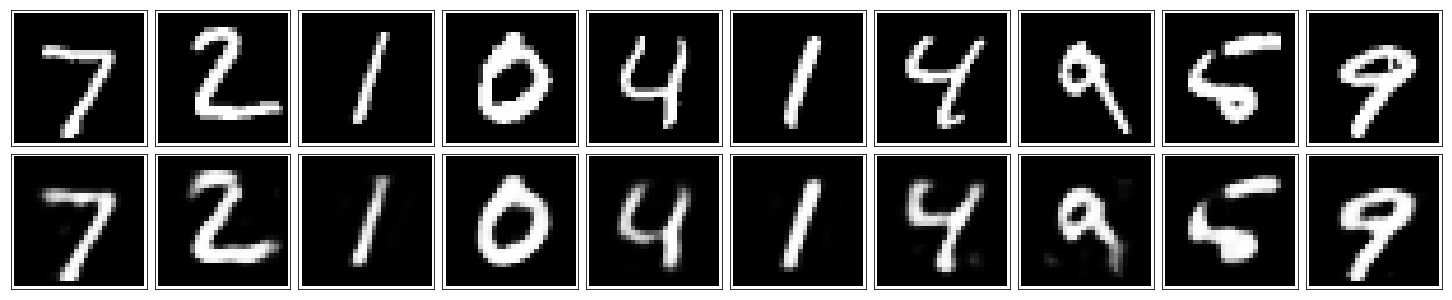

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

#약간의 원본 손실이 일어난다.

In [9]:
sess.close() #사용 후 세션을 닫아주는 게 좋다.

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.